In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('ratings_sample.csv')
data = data.drop('overview', axis=1)
data = data.drop('user_id', axis=1)

In [3]:
data.head()

,movie_id,rating,genres,production_companies,production_countries,release_year
0,gods+and+monsters+1998,4,Drama,Lions Gate Films Flashpoint (I) Showtime Networks,United Kingdom United States of America,1998.0
1,stargate+1994,3,Action Adventure Science Fiction,Centropolis Entertainment StudioCanal Carolco ...,France United States of America,1994.0
2,toy+story+1995,3,Animation Comedy Family,Pixar Animation Studios,United States of America,1995.0
3,friends+with+benefits+2011,4,Romance Comedy,Castle Rock Entertainment Screen Gems Olive Br...,United States of America,2011.0
4,sleeper+1973,4,Comedy Romance Science Fiction,Rollins-Joffe Productions,United States of America,1973.0


In [4]:
print(data.isnull().sum())

movie_id                 0
rating                   0
genres                   2
production_companies    13
production_countries     4
release_year             0
dtype: int64


In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

data[['genres', 'production_companies', 'production_countries', 'release_year']] = imputer.fit_transform(data[['genres', 'production_companies', 'production_countries', 'release_year']])

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['genres'] = le.fit_transform(data['genres'])
data['production_companies'] = le.fit_transform(data['production_companies'])
data['production_countries'] = le.fit_transform(data['production_countries'])
data['release_year'] = le.fit_transform(data['release_year'])

In [7]:
X = data.drop(columns=['rating'])
y = data['rating']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train[["movie_id", "genres", "production_companies", "production_countries", "release_year"]].astype(str).agg(" ".join, axis=1))
X_test_tfidf = vectorizer.transform(X_test[["movie_id", "genres", "production_companies", "production_countries", "release_year"]].astype(str).agg(" ".join, axis=1))

In [10]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train_tfidf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict(X_test_tfidf)

In [12]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9764844197083508


In [13]:
predictions = pd.DataFrame({'Actual Rating': y_test, 'Predicted Rating': y_pred})
print(predictions.head())

      Actual Rating  Predicted Rating
957               1          3.340560
1036              4          3.813381
1827              4          2.794610
396               4          3.839056
1272              4          3.595806


In [14]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.08104233040810205

In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.7949911856651306


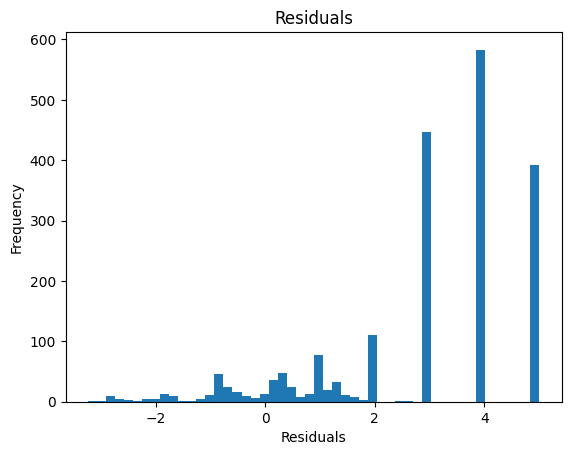

In [16]:
import matplotlib.pyplot as plt
y_pred_padded = np.pad(y_pred, (0, len(y) - len(y_pred)), mode='constant')
y_pred_padded = y_pred_padded.reshape(-1)  # Reshape y_pred_padded to 1D
residuals = y - y_pred_padded

# Plot residuals
plt.hist(residuals, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals')
plt.show()